Vincent Thong et Maxime Boy-Arnould

# IREN Project - Navire 2023

## Réseau de neurone convolutionnel (CNN) pour la classification d'image de navires

Description du projet : [lien](http://www.ricou.eu.org/iren/notes_rn.html#Projet%20navires%202023)

Le projet a pour but de réaliser de faire à la main un réseau de neurone convolutifs (CNN) qui classent le mieux possible des images de navire par apprentissage supervisé dans le domaine de la vision par ordinateur.

La principale caractéristique des CNN réside dans leur capacité à apprendre et à extraire des caractéristiques pertinentes directement à partir des images brutes grâce à l'utilisation de couches de convolution spéciales qui effectuent des opérations de filtrage sur l'image d'entrée.
([Wiki](https://en.wikipedia.org/wiki/Convolutional_neural_network))

Ce premier réseau de neurone a été fait avec moins de 30 couches.


## Sommaire
0. Préambule (mise en place de l'environnement)
1. Mise en place des données
    1. Aperçu et création de nouveaux jeux de données
    2. Data augmentation
3. Création du modèle
4. Entrainement du Modèle
5. Précision du modèle
6. Soumission
7. Conclusion



# Mise en place de l'environnement
## Bibliothèques importées

In [28]:
import numpy as np # algèbre linéaire
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import FileLink
from IPython.display import display
import skimage
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
# Autocompletion
%config Completer.use_jedi = False

In [29]:
#tensorflow & keras import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models #build model, create datasets
from tensorflow.keras import regularizers#regularizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Vérification du CPU et GPU

In [30]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0


# Mise en place des données

Pour développer et entraîner notre Convolutional Neural Network (CNN) pour la classification de navires, nous devons mettre en place des ensembles de données appropriés.

La qualité et la diversité de nos données joueront un rôle crucial dans la capacité de notre modèle à généraliser et à effectuer des classifications précises.

Nous avons à notre disposition d'un répertoire de 35515 images répartis dans 10 répertoires différents. Le nom des répertoires correspondent aux classes a déterminer.
Nous disposons aussi d'un fichier test.npy qui nous permettra d'évaluer notre réseau pour la soumission.

Regardons de plus près nos données.

## Aperçu des données

In [31]:
#chemin du répertoire des données en entrée
directory = '/kaggle/input/navires-2023-la-mano'
data_dir = directory + '/ships16x24/ships_16x24_10cat/data/'
test_file = directory + '/test.npy'
num_classes = 10  # Nombre total de catégories

In [32]:
def get_label(dir_path):
    return [element for element in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, element))]

def count_files(directory):
    count = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        count += len(filenames)
    return count

import pandas as pd

def files_by_category(directory):
    subdirectories = get_label(directory)
    file_counts = []
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        file_count = count_files(subdir_path)
        file_counts.append(file_count)
    
    data = {"class_names": subdirectories, "File Count": file_counts}
    df = pd.DataFrame(data)
    display(df)
    return data
    
    
files_label = files_by_category(data_dir)

,class_names,File Count
0,methanier_scaled,3199
1,corvette_scaled,2682
2,containership_scaled,5454
3,cruiser_scaled,5382
4,cv_scaled,1827
5,coastguard_scaled,3118
6,destroyer_scaled,5107
7,smallfish_scaled,3000
8,submarine_scaled,2602
9,tug_scaled,3144


Nous avons 10 classes et la répartition de nos fichiers ne sont pas uniformes. Pour notre modèle, il faudra 


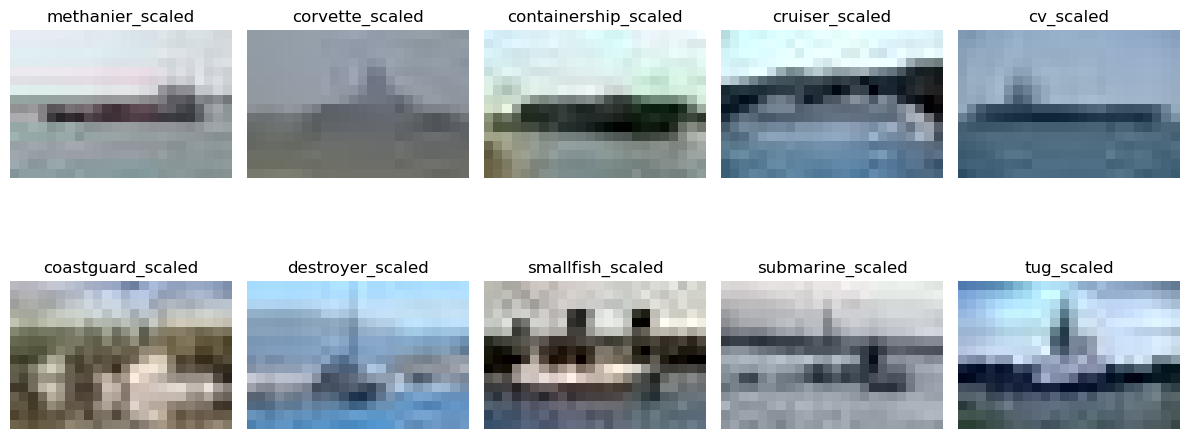

In [33]:
def plot_file_per_subdirectory(directory):
    """
    Plot one file per subdirectory in the specified directory.

    Args:
        directory (str): Path to the directory containing the subdirectories.

    Returns:
        None
    """
    subdirectories = os.listdir(directory)
    num_subdirectories = len(subdirectories)
    num_rows = 2
    num_cols = (num_subdirectories + 1) // num_rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axs = axs.flatten()

    for i, subdir in enumerate(subdirectories):
        subdir_path = os.path.join(directory, subdir)
        file_list = os.listdir(subdir_path)
        if file_list:
            file_path = os.path.join(subdir_path, file_list[0])
            image = plt.imread(file_path)
            axs[i].imshow(image)
            axs[i].set_title(subdir)
            axs[i].axis("off")

    # Remove any unused subplots
    for j in range(num_subdirectories, num_rows * num_cols):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()
    
plot_file_per_subdirectory(data_dir)

## Aperçu des fichiers des tests de soumission de la compétition

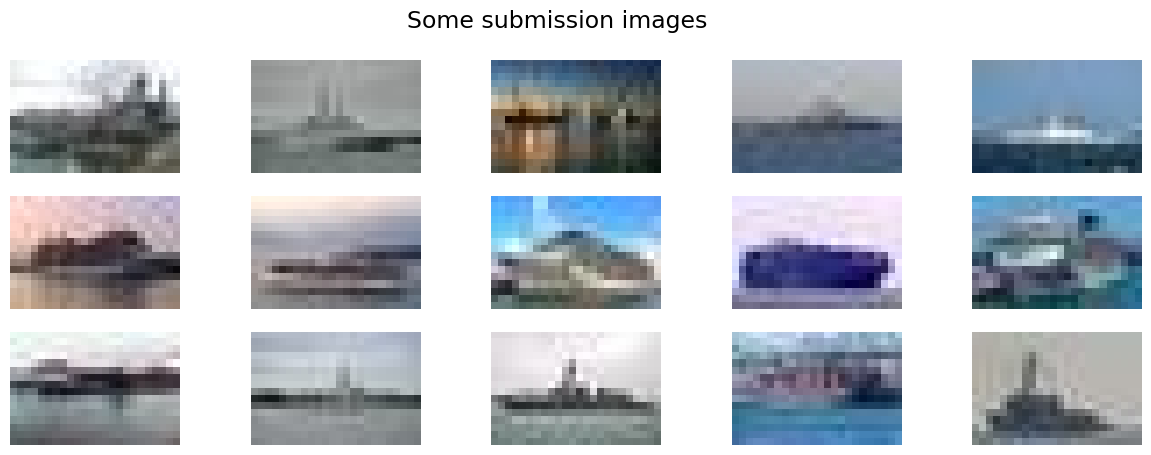

In [34]:
X_submission = np.load(test_file, allow_pickle=True)
X_submission = X_submission.astype('float32') / 255

X_submission.shape, X_submission.dtype

ax = plt.figure(figsize=(15,5))
nb_image_row = 5
plt.suptitle('Some submission images', fontsize=17)
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_submission[np.random.randint(len(X_submission))])
    plt.axis('off')
plt.show()

## Chargement de d'ensembles de donnée

Nous utilisons  **keras.utils.image_dataset_from_directory** pour charger nos ensembles d'entraînement et de validation, et de test. Elle a pour avantage de répartir les données en sous ensembles équilibrés de chaque catégorie.

Les labels des données sont inférés, et correspondent au noms des répertoires et le mode de label est configuré sur "categorical" pour indiquer que les labels sont représentés par des vecteurs binaires.

Cette approche de chargement de données offre une solution pratique et efficace pour l'entraînement de modèles d'apprentissage automatique sur des ensembles d'images à partir de répertoires déja labellisés. De plus, l'utilisation d'une Seed fixe permet de reproduire les résultats, ce qui est essentiel pour garantir la cohérence des expériences et faciliter la comparaison des résultats entre différentes exécutions.

Maintenant, après avoir créer nos jeu de données, ayons un aperçu d'une image de chaque classe de jeu données et des images du test.

In [35]:
# initialisation des générateurs de nombre aléatoires dans Numpy et TensorFlow 
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

In [36]:
image_width, image_height, rgb = 16,24,3  # Dimension des images
# chargement des ensembles de données
train_ds = keras.utils.image_dataset_from_directory(data_dir,seed=seed, labels='inferred', label_mode='categorical', image_size=(image_width,image_height), validation_split=0.2, subset="training")
validation_ds = keras.utils.image_dataset_from_directory(data_dir,seed=seed, labels='inferred', label_mode='categorical', image_size=(image_width,image_height), validation_split=0.2, subset="validation")
test_ds = keras.utils.image_dataset_from_directory(data_dir,seed=seed, labels='inferred', label_mode='categorical', image_size=(image_width,image_height), validation_split=0.1,subset="validation")

Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Found 35515 files belonging to 10 classes.
Using 7103 files for validation.
Found 35515 files belonging to 10 classes.
Using 3551 files for validation.


## Augmentation des données

L'augmentation d'ensemble de donnée (Data augmentation) est un moyen d'améliorer nos jeux de donnée.. Cela aide à prévenir le surapprentissage en exposant le modèle à une plus grande variété de situations et de variations possibles dans les données. 

Le surapprentissage se produit lorsqu'un modèle d'apprentissage automatique s'adapte trop étroitement aux données d'entraînement spécifiques sur lesquelles il a été formé, au point de perdre sa capacité à généraliser et à faire des prédictions précises sur de nouvelles données.

Pour améliorer la diversité de notre ensemble d'entrainement, nous allons faire des transformation aléatoires aux images existantes:
* Faire un zoom aléatoire,
* Faire un retournement horizontal

Un retournement vertical n'est pas pertinent pour des images de navires, la mer est toujours situé en bas de l'image. 

Nous allons aussi redéfinir la taille de nos images pour quelles soient carrées, et donc mieux uniformiser, et enfin normaliser les images 
pour standardiser nos données afin de mettre à la même échelle les caractéristiques de nos données (éviter que certaines domine les autres) et accélérer la convergence.

Le réseau de neurone MobileNet conçu par Google est un réseau neuronal convolutif simple mais efficace, peu intensif en termes de puissance de calcul, conçu spécifiquement pour les applications de vision sur mobile. MobileNet est largement utilisé dans de nombreuses applications du monde réel, notamment la détection d'objets, les classifications détaillées, les attributs faciaux et la localisation. [MobileNets](https://ai.googleblog.com/2017/06/mobilenets-open-source-models-for.html)

In [37]:
def image_augmentation(dataset):
    zoom_layer = layers.RandomZoom(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2), interpolation='bilinear')
    flip_layer = layers.RandomFlip('horizontal')
    augmented_data = dataset.map(lambda x, y: (zoom_layer(x), y))
    augmented_data = augmented_data.map(lambda x, y: (flip_layer(x), y))
    return augmented_data


In [38]:
augmented_train = image_augmentation(train_ds)


Dans le code suivant nous initialisons le modèle auquel nous ajouterons la couche de changement de la taille pour augmenter n'importe quel ensemble de données.
L'avantage de traiter de cette manière est qu'elle est plsu claire à comprendre et facile à utliser. 
Nous allons aussi normaliser pour standardiser nos données afin de mettre à la même échelle les caractéristiques de nos données (éviter que certaines domine les autres) et accélérer la convergence.
Mais l'inconvénient de cette méthode est l'ajout de couches alors qu'on est limité dans le nombre de couches mais aussi cela peut rendre plus lent le modèle.

In [39]:
with tf.device('/gpu:0'):
        #création du modèle
        model =  models.Sequential([
                    layers.Resizing(24,24,interpolation='bicubic', input_shape=(image_width, image_height, 3)),
                    layers.Rescaling(1. / 255)
                    ])

### Exemple d'image traitée:

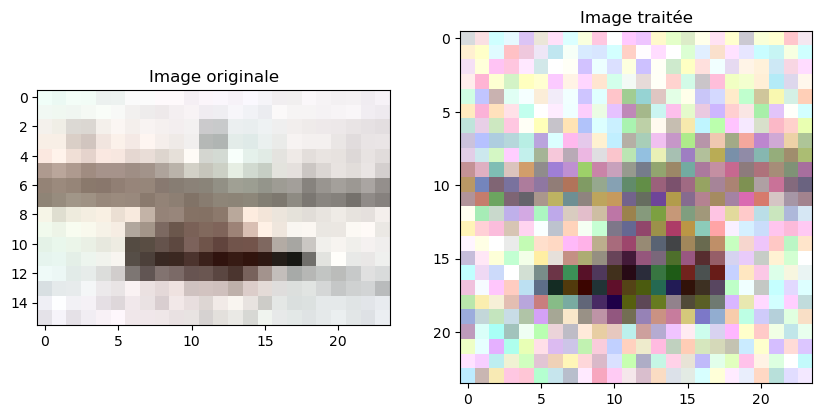

In [40]:
import cv2
#an exemple of image after Augmentation
image_path = '/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/coastguard_scaled/0.jpg'  # Remplacez par le chemin vers votre image
image = cv2.imread(image_path)
image = image.astype(np.float32) / 255.0
image = np.expand_dims(image, axis=0)

# Prétraiter l'image en utilisant les couches spécifiées
resized_image = cv2.resize(image[0], (24, 24), interpolation=cv2.INTER_LINEAR)
zoomed_image = resized_image + np.random.uniform(-0.2, 0.2, size=resized_image.shape)
flipped_image = np.fliplr(zoomed_image)
preprocessed_image = flipped_image[np.newaxis, :, :, :]

# Tracer l'image originale et l'image prétraitée
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Tracer l'image originale
axs[0].imshow(image[0])
axs[0].set_title('Image originale')

# Tracer l'image traitée
axs[1].imshow(preprocessed_image[0])
axs[1].set_title('Image traitée')

plt.show()

## Création du Modèle CNN

Nous allons maintenant créer notre CNN avec les couches suivantes: 

* **Convolution 2D** :  Cette couche convolutive applique des filtres d'une certaine taille à l'image en utilisant la fonction d'activation ReLU pour introduire la non-linéarité dans le modèle.

La fonction d'activation **Relu** est une fonction non linéaire largement utilisée dans les réseaux de neurones. Elle permet d'introduire une non-linéarité dans le modèle, ce qui est important pour capturer des relations complexes entre les données. Elle est également moins sujette au problème de disparition du gradient par rapport à d'autres fonctions d'activation telles que la sigmoïde ou la tangente hyperbolique.

* **Batch Normalization** :  Cette couche de normalisation par lots normalise les activations de chaque canal en ajustant la moyenne et la variance.
* **MaxPooling2D**: Cette couche de pooling réduit la taille spatiale de l'image en conservant les valeurs maximales de chaque région.
* **Dropout** : Cette couche de désactivation met aléatoirement à zéro une partie des activations d'entrée pendant l'entraînement, ce qui aide à prévenir le surapprentissage.
* **Conv2DTranspose** : Cette couche transpose la convolution en appliquant 128 filtres de taille 3x3 à l'image pour augmenter sa taille spatiale, faire du suréchantillonage.
* **Flatten** : Cette couche transforme l'image 2D en un vecteur 1D en l'aplatissant et permet de connecter les couches de convolution avec celles 'Dense'.
* **Dense** ou entièrement connectée: Cette couche est chargée de connecter chaque neurone de la couche précédente à chaque neurone de la couche suivante.
* Dense(10, activation='**softmax**') : Cette dernière couche dense est une couche entièrement connectée avec 10 neurones correspondant aux classes de sortie du modèle, et elle utilise la fonction d'activation softmax pour obtenir des probabilités de classification.

Notre modèle est une séquence de toutes ces couches, composée de plusieurs bloc de convolution.
un Bloc de convolution est composé de cette séquence : 
2D Convolution -> BatchNormalization -> 2D Convolution -> BatchNormalization -> MaxPooling2D -> Dropout

In [41]:
# with GPU
with tf.device('/gpu:0'):
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.1))
        model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
        #model.add(layers.BatchNormalization())
        model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.7))
        model.add(layers.Flatten())           
        model.add(layers.Dense(512, activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.1))
        model.add(layers.Dense(10, activation='softmax'))


### La compilation

Lors de l'apprentissage, l'optimiseur utilisé sera Adam qui semble être le plus efficient après plusieurs test. La vitesse d'apprentissage sera de 0.01 plus lent que celui par défaut c'est 0.001. Cela permettra un ajustement des poids plus stable et une convergence lente, et donc une meilleure précision mais nécessitera plus d'itération (epochs).



In [42]:
from keras.optimizers import Adadelta, Adam
model.compile(optimizer=Adam(0.005), loss='categorical_crossentropy', metrics=['accuracy'])

La fonction de perte est 'categorical_crossentropy' qui est adaptée pour les classes exclusives, une image ne peut appartenir qu'à une seule classe

### Résumé de la construction

In [43]:
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 24, 24, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 24, 24, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 256)       7168      
                                                                 
 batch_normalization_4 (Batc  (None, 22, 22, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 256)       590080    
                                                                 
 batch_normalization_5 (Batc  (None, 20, 20, 256)      1024      
 hNormalization)                                      

In [44]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  18


# Entrainement du modèle

Le modèle est entrainé avec nos deux ensembles de données d'entrainement et de validation.

Une 'epoch' correspond à une itération complète de l'algorithme d'optimisation sur les données d'entrainement divisé en lots, permet de calculer les gradients  et de  mettre à jour les poids du modèle.

In [45]:
from keras.callbacks import ModelCheckpoint
# keep the best weights
checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

In [46]:
epochs = 150
batch_size=256

In [ ]:
import tensorflow.keras.backend as K

with tf.device('/gpu:0'):
    K.clear_session()
    history = model.fit(augmented_train, validation_data=validation_ds, epochs=epochs, batch_size=batch_size, callbacks=[model_checkpoint_callback])

Epoch 1/150
888/888 [==============================] - ETA: 0s - loss: 2.0647 - accuracy: 0.3159
Epoch 1: val_accuracy improved from -inf to 0.29086, saving model to model_checkpoint
888/888 [==============================] - 639s 718ms/step - loss: 2.0647 - accuracy: 0.3159 - val_loss: 2.3282 - val_accuracy: 0.2909
Epoch 2/150
888/888 [==============================] - ETA: 0s - loss: 1.5326 - accuracy: 0.4718
Epoch 2: val_accuracy did not improve from 0.29086
888/888 [==============================] - 630s 709ms/step - loss: 1.5326 - accuracy: 0.4718 - val_loss: 4.1235 - val_accuracy: 0.1543
Epoch 3/150
888/888 [==============================] - ETA: 0s - loss: 1.3798 - accuracy: 0.5243
Epoch 3: val_accuracy improved from 0.29086 to 0.55512, saving model to model_checkpoint
888/888 [==============================] - 632s 712ms/step - loss: 1.3798 - accuracy: 0.5243 - val_loss: 1.2853 - val_accuracy: 0.5551
Epoch 4/150
888/888 [==============================] - ETA: 0s - loss: 1.3049 

In [ ]:
#chargement du modèle
#model = models.load_model('/kaggle/working/mon_modele.h5')
# Sauvegarde du modèle
model.save('/kaggle/working/mon_modele.h5')

## Analyse des résultats d'entrainenment

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



## Résultat dans la version 39 (même réseau de neurone que cette version)

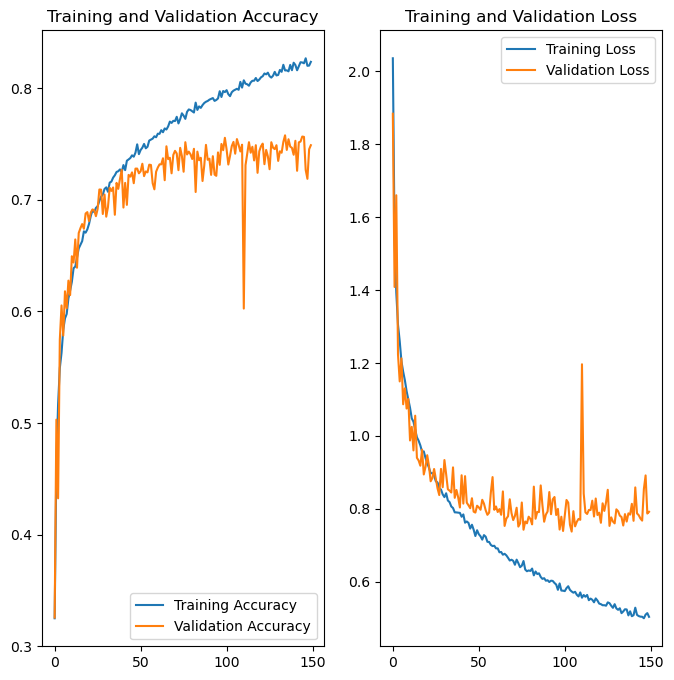

Au début de l'entrainement, les précisions de la validation et de l'entrainement augmentent rapidement autour de la 30eme epoch puis ralentissent ensuite. La précision validation atteint progressisvement sa limite à la 75ème epoch. Vers la fin de  l'entrainement à la 150ème epochs, la précision de l'entrainement atteint 83% de précision mais celle de la validation tourne autour de 75%. L'indicateur le plus important dans notre cas est la validation.
Une trop grande différence entre la précision d'entraînement et celle de la validation peut indiquer un problème de surapprentissage, également connu sous le nom d'overfitting. Dans notre cas, elle est de 6 points, il y a donc un surapprentissage. Le surapprentissage se produit lorsque le modèle s'est trop adapté aux données d'entraînement spécifiques et ne parvient pas à généraliser correctement sur de nouvelles données, ce qui se reflète dans une baisse de performance sur l'ensemble de validation. 
Dans ce cas précis, une différence de 21 points de pourcentage est assez significative. Cela suggère que le modèle est performant sur les données d'entraînement, mais ne se généralise pas aussi bien sur de nouvelles données, ce qui peut limiter son utilité dans des scénarios réels. Il se peut aussi que le modèle est trop grand.

### Evaluation de la précision sur des données de tests

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
acc = model.evaluate(test_ds)[1]
print("The model accuracy over the test data: {:.2%}".format(acc))

## La matrice de confusion 

[](http://)

Une matrice de confusion est utilisée pour évaluer la qualité des prédictions d'un système de classification. Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe prédite.

Les éléments diagonaux de la matrice représentent le nombre de points pour lequel l'étiquette prédite est égale à l'étiquette réelle, tandis que les éléments hors-diagonaux représentent les points qui ont été mal étiquetés par le classifieur. Ce sont soit des vrais négatifs, ou soit des faux positifs.

Plus les valeurs diagonales de la matrice de confusion sont élevées, meilleur est le résultat, indiquant de nombreuses prédictions correctes et donc un fort accord entre les prédictions et les étiquettes réelles. 

La matrice de confusion est un outil utile pour évaluer les performances de notre classifieur et pour identifier les types d'erreurs qu'il commet.


In [ ]:
import seaborn as sns

true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = np.argmax(true_labels, axis=1)

# Get predicted labels using model.predict
predicted_labels = np.argmax(model.predict(test_ds), axis=1)

# Create confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
conf_matrix_array = conf_matrix.numpy()
#display(conf_matrix_array)

## Résultat obtenu dans la version 39

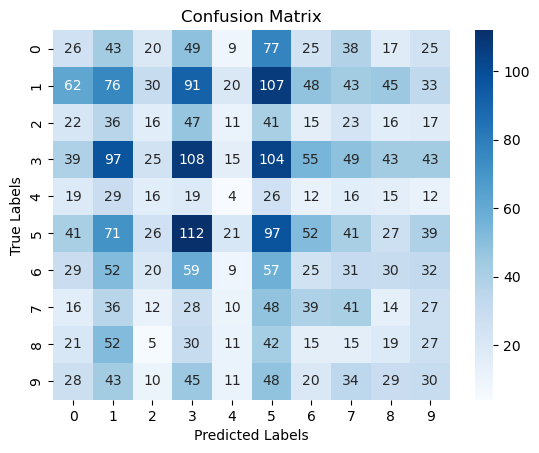



En examinant les résultats, nous pouvons constater que certaines classes ont été prédites de manières plus précises que d'autres, comme la classe 3, la classe 1 et la classe 5. 
Notre modèle semble aussi avoir du mal à prédire correctement les autres classes et leurs caractéritiques, en particulier les classes 4 et 2.


Soumission et test avec le fichier npy


In [ ]:
test_data = np.load('/kaggle/input/navires-2023-la-mano/test.npy')


predictions = model.predict(test_data)

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
print(len(predicted_labels))

df = pd.DataFrame({"Category":predicted_labels})
df.to_csv("submission.csv", index_label="Id")

import os
os.chdir(r'/kaggle/working')
FileLink(r'submission.csv')

In [ ]:
model.save('/kaggle/working/mon_modele.h5')
FileLink(r'mon_modele.h5')

In [ ]:
!head submission.csv


## Conclusion

En conclusion, nous avons tout d'abord exploité au maximum les données du concours avec de l'augmentation d'image et de pré-processing pour permettre a une modèle de convolution simple de moins de 30 couches d'obtenir des meilleurs résultats.
Nous avons beaucoup apris sur les réseau de neuronnes grace à ce projet et il reste des manières d'obtenir des résultats encore meilleur: techniques comme le transfert d'apprentissage pourraient être explorées pour bénéficier de la puissance des modèles pré-entraînés sur des tâches similaires.

Vincent Thong
Maxime Boy-Arnould